iteration: 18 obstacle nearby!!
RRT* Path Planning...
Path found!
[[144.7376506656774, 85.52958876009406], [140.7412404909011, 78.43713851536715], [130.88497315126406, 78.63700020059119], [121.12183162851574, 76.85275105184269], [112.31475666645483, 74.50077323751216], [108.15542039767762, 71.7258999425247], [101.42042986554777, 66.47118270596158], [97.43502695410437, 58.183840776036725], [95.21328096379857, 53.7045724479992], [94.98607929355322, 44.60825003329842], [93.45214766278721, 35.79956434920602], [86.02819266882112, 29.74280669546385], [81.63829799949913, 27.349310342373165], [72.19198229017812, 28.512056503500283], [63.45182085563011, 32.43101155368951], [60.21749099004786, 41.38103672312036], [54.28562965468482, 49.39027251929791], [48.63115263915056, 55.310669804918874], [41.428073427976294, 61.30206768644341], [40.53343491109788, 66.22137880936678], [40.851386763434455, 75.6169807843743], [39.170038001674364, 80.32580933735092], [35.7358429374855, 89.26743121668385], [33.6

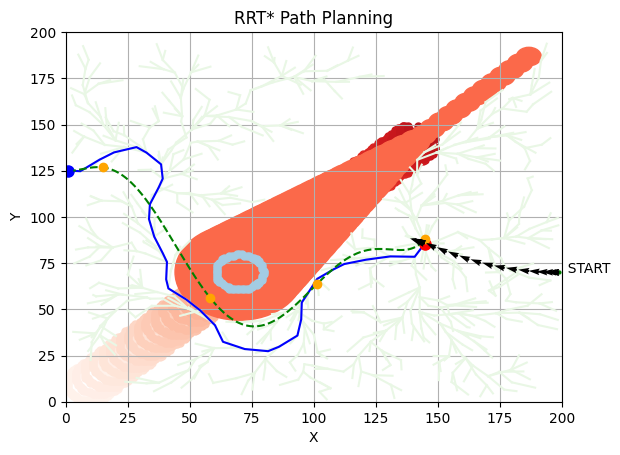

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0.0

class RRTStar:
    def __init__(self, start, goal, obstacle_list, x_limit, y_limit, step_size=1.0, max_iterations=1000):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.obstacle_list = obstacle_list
        self.x_limit = x_limit
        self.y_limit = y_limit
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.node_list = [self.start]

    def generate_random_node(self):
        x = np.random.uniform(self.x_limit[0], self.x_limit[1])
        y = np.random.uniform(self.y_limit[0], self.y_limit[1])
        return Node(x, y)

    def find_nearest_node(self, node):
        distances = [(n.x - node.x) ** 2 + (n.y - node.y) ** 2 for n in self.node_list]
        nearest_index = np.argmin(distances)
        return self.node_list[nearest_index]

    def is_collision_free(self, node):
        for obstacle in self.obstacle_list:
            if (node.x - obstacle[0]) ** 2 + (node.y - obstacle[1]) ** 2 <= obstacle[2] ** 2:
                return False
        return True

    def steer(self, from_node, to_node):
        angle = np.arctan2(to_node.y - from_node.y, to_node.x - from_node.x)
        new_x = from_node.x + self.step_size * np.cos(angle)
        new_y = from_node.y + self.step_size * np.sin(angle)
        return Node(new_x, new_y)

    def calculate_cost(self, from_node, to_node):
        return from_node.cost + np.sqrt((to_node.x - from_node.x) ** 2 + (to_node.y - from_node.y) ** 2)

    def is_goal_reachable(self, node):
        return np.sqrt((node.x - self.goal.x) ** 2 + (node.y - self.goal.y) ** 2) <= self.step_size

    def rewire(self, new_node):
        for node in self.node_list:
            if node != new_node and np.sqrt((node.x - new_node.x) ** 2 + (node.y - new_node.y) ** 2) <= self.step_size:
                new_cost = self.calculate_cost(new_node, node)
                if new_cost < node.cost:
                    node.parent = new_node
                    node.cost = new_cost

    def bspline_interpolation(self, path, degree=3, num_points=100):
        # Remove duplicate points from the path to ensure strictly increasing x values
        unique_path = np.unique(path, axis=0)

        x = unique_path[:, 0]
        y = unique_path[:, 1]
        tck = make_interp_spline(x, y, k=degree)
        spline = lambda xi: np.array([tck(xi), tck(xi, 1)])
        x_new = np.linspace(min(x), max(x), num_points)
        y_new = spline(x_new)
        return x_new, y_new

    def find_path(self):
        for iteration in range(self.max_iterations):
            random_node = self.generate_random_node()
            nearest_node = self.find_nearest_node(random_node)
            new_node = self.steer(nearest_node, random_node)

            if self.is_collision_free(new_node):
                near_nodes = [node for node in self.node_list if np.sqrt((node.x - new_node.x) ** 2 + (node.y - new_node.y) ** 2) <= 2 * self.step_size]
                min_cost_node = nearest_node
                min_cost = self.calculate_cost(nearest_node, new_node)

                for near_node in near_nodes:
                    if near_node.cost + np.sqrt((near_node.x - new_node.x) ** 2 + (near_node.y - new_node.y) ** 2) < min_cost:
                        min_cost_node = near_node
                        min_cost = near_node.cost + np.sqrt((near_node.x - new_node.x) ** 2 + (near_node.y - new_node.y) ** 2)

                new_node.parent = min_cost_node
                new_node.cost = min_cost
                self.node_list.append(new_node)
                self.rewire(new_node)

                if self.is_goal_reachable(new_node):
                    goal_node = Node(self.goal.x, self.goal.y)
                    goal_node.parent = new_node
                    goal_node.cost = new_node.cost + np.sqrt((new_node.x - self.goal.x) ** 2 + (new_node.y - self.goal.y) ** 2)
                    self.node_list.append(goal_node)
                    return self.extract_path(goal_node)

        return None

    def extract_path(self, goal_node):
        path = [[goal_node.x, goal_node.y]]
        current_node = goal_node

        while current_node.parent is not None:
            current_node = current_node.parent
            path.append([current_node.x, current_node.y])

        return path[::-1]

    def plot(self, path=None):
        for obstacle in self.obstacle_list:
            circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color=plt.cm.Reds(0.5))
            plt.gca().add_patch(circle)
        for node in self.node_list:
            if node.parent is not None:
                plt.plot([node.x, node.parent.x], [node.y, node.parent.y], '-', color=plt.cm.Greens(0.1))
        if path is not None:
            plt.plot([x for x, y in path], [y for x, y in path], '-b')
        plt.plot(self.start.x, self.start.y, 'ro', markersize=8)
        plt.plot(self.goal.x, self.goal.y, 'bo', markersize=8)
        plt.xlim(self.x_limit)
        plt.ylim(self.y_limit)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('RRT* Path Planning')
        plt.grid(True)
        # plt.show()

size = 150

iteration = 0
iteration_since_see = 1

x_range = 50
y_range = 50

initial_obstacle_position = [10., 10., np.pi/4]
current_obstacle_position = initial_obstacle_position
obstacle_old_position = [0., 0.]
dodge_slope = -(current_obstacle_position[2])**(-1)
obstacle_velocity = 5.
obstacle_radius = 10.    # (R)
obstacle_x_velo = obstacle_velocity* np.cos(current_obstacle_position[2])
obstacle_y_velo = obstacle_velocity* np.sin(current_obstacle_position[2])

robot_radius = 17.    # cm (r)
initial_robot_position = [199., 70., np.pi]    # [x, y, theta]
current_robot_position = initial_robot_position
robot_velocity = 0.
robot_omega = 0.
original_robot_velo = robot_velocity
original_robot_omega = robot_omega
robot_x_velo = robot_velocity* np.cos(current_robot_position[2])
robot_y_velo = robot_velocity* np.sin(current_robot_position[2])
see_obstacle = 0

temp_target = [0., 0., 0.]
target = [1., 125., np.pi]
diff_arr = [0., 0., 0.]
controller_index = 0

sampling_freq = 1.    # Hz
safety_margin = 3*robot_radius

turn = 0
nearby = 0

# RRT* parameters
start = (0., 0.)
goal = (0., 0.)
obstacle_list = []  # Format: (x, y, radius), the position after robot see it
x_limit = (0., 200.)
y_limit = (0., 200.)
step_size = 5.0
max_iterations = 3000
# RRT* parameters

def calculate_slope(data):
    slopes = []
    for i in range(1, len(data)):
        x_diff = data[i][0] - data[i - 1][0]
        y_diff = data[i][1] - data[i - 1][1]
        slope = y_diff / x_diff
        slopes.append(slope)
    return slopes

def crossing(x, y, iteration, colorcode, zorder_index):
    if colorcode == 1:
        plt.plot(x, y, marker='o', markersize=5, color=plt.cm.Reds((iteration+1)/50), zorder=zorder_index)
    elif colorcode == 2:
        plt.plot(x, y, marker='o', markersize=5, color=plt.cm.Greens((iteration+1)/50), zorder=zorder_index)
    elif colorcode == 3:
        plt.plot(x, y, marker='o', markersize=5, color=plt.cm.Blues((iteration+1)/50), zorder=zorder_index)

def do_RRTstar():
    global start, goal, obstacle_list, x_limit, y_limit, step_size, max_iterations
    rrt_star = RRTStar(start, goal, obstacle_list, x_limit, y_limit, step_size, max_iterations)
    path = rrt_star.find_path()
    if path is not None:
        print("Path found!")
        print(path)
        print("The slope: ", current_robot_position[2])
        # x_sp, y_sp = rrt_star.bspline_interpolation(path)  # Get the B-spline interpolated curve
        # plt.plot(x_sp, y_sp[1], color='purple')  # Plot the B-spline curve
        rrt_star.plot(path)
    else:
        print("Path not found.")

def controller(diff_x, diff_y, diff_theta, iteration, initial_velocity, initial_omega):
    global robot_velocity, robot_omega, current_robot_position, robot_x_velo, robot_y_velo, turn
    if turn:
        k1 = 5000e-4
        k2 = (0.1*k1)
    else:
        k1 = (1100e-4)      # speed
        k2 = (5*k1)      # trajectory

    z1 = diff_theta
    z2 = diff_x*np.cos(diff_theta) + diff_y*np.sin(diff_theta)
    z3 = diff_x*np.sin(diff_theta) - diff_y*np.cos(diff_theta)
    
    x1 = z1
    x2 = z2
    x3 = -2*z3+z1*z2

    denominator = x1**2+x2**2
    u1 = -k1*x1 + ((k2*x3)/denominator)*x2
    u2 = -k1*x2 - ((k2*x3)/denominator)*x1
    
    # get start from zero velocity
    initial_region = 30
    if iteration <= initial_region:
        velocity = (iteration*((iteration+1)/(initial_region*1.1))*(u2 + z3*u1) + (initial_region-iteration)*initial_velocity)/initial_region
        omega = (iteration*((iteration+0.1*initial_region)/(initial_region*1.1))*u1 + (initial_region-iteration)*initial_omega)/initial_region
    else:
        velocity = 1*(u2 + z3*u1)   # the linear velocoty of the robot
        omega = 1*u1

    if ((velocity < 0 and (0<=current_robot_position[2]%(2*np.pi) and current_robot_position[2]%(2*np.pi)<=0.5*np.pi)or(1.5*np.pi<=current_robot_position[2]%(2*np.pi) and current_robot_position[2]%(2*np.pi)<=2*np.pi))
        or (velocity > 0 and (0.5*np.pi<=current_robot_position[2]%(2*np.pi) and current_robot_position[2]%(2*np.pi)<=1.5*np.pi))):
        # turn around
        print("velo:", velocity, "orientation:", current_robot_position[2])
        current_robot_position[2] += np.pi # here is # of degree the robot turns 
        if current_robot_position[2] >= 2*np.pi:
            current_robot_position[2] -= 2*np.pi
        return -1
    else:
        # limit the speed
        if velocity > 5.:
            velocity = 5.   
        elif velocity < -5.:
            velocity = -5.
        # print("velo.:", velocity)
        robot_velocity = velocity
        robot_omega = omega
        robot_x_velo = -robot_velocity* np.cos(current_robot_position[2])      # the negative sign should be modified
        robot_y_velo = -robot_velocity* np.sin(current_robot_position[2])      # the negative sign should be modified
        return 1

# plotting trajectory
while (0<current_obstacle_position[0] and current_obstacle_position[0]<size and 0<current_obstacle_position[1] and current_obstacle_position[1]<size 
       or 0<current_robot_position[0] and current_robot_position[0]<size and 0<current_robot_position[1] and current_robot_position[1]<size):
    # plot the starting point
    if iteration == 0:
        plt.quiver(current_robot_position[0], current_robot_position[1], 
                   np.cos(current_robot_position[2]), np.sin(current_robot_position[2]),
                     scale=1, units='xy')
        plt.plot(current_robot_position[0], current_robot_position[1], marker="o", markersize=2, markeredgecolor="green", markerfacecolor="green")
        plt.text(current_robot_position[0], current_robot_position[1], '  START', zorder = 3)

    # check if robot near the obstacle
    if np.sqrt((current_obstacle_position[0]-current_robot_position[0])**2+
               (current_obstacle_position[1]-current_robot_position[1])**2
               ) <= obstacle_radius+robot_radius+safety_margin and turn == 0:
        print("iteration:", iteration+1, "obstacle nearby!!")
        print('RRT* Path Planning...')
        nearby = 1
        see_obstacle = 1

        # RRT*
        start = (current_robot_position[0], current_robot_position[1])
        goal = (target[0], target[1])        
        # RRT*
        
        # plt.plot(temp_target[0], temp_target[1], marker='x', markersize=10, color = 'g')
        # print(temp_target)
        controller_index = 0
        turn = 1      
    else:
        # controller to distination
        for j in range(3):
            diff_arr[j] = current_robot_position[j] - target[j]

        # control goes here
        control_status = controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index, robot_velocity, robot_omega)
        # print(control_status)
        if control_status != -1:
            controller_index += 1
        else:
            continue

    # calculate the difference
    # if turn == 1:
    #     # break
    #     for j in range(3):
    #         diff_arr[j] = current_robot_position[j] - temp_target[j]
    #     controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index) 
    #     controller_index += 1  
    #     # print(robot_x_velo, robot_y_velo, robot_omega)   # print for debugging
    #     if np.sqrt((current_robot_position[0]-temp_target[0])**2 + 
    #                (current_robot_position[1]-temp_target[1])**2) < 1.2*robot_radius:  # if robot is close enough to temp. distination, continue
    #         turn = 0
    #         controller_index = 0

    # plot the current status (arrow)
    if not turn:
        plt.quiver(current_robot_position[0], current_robot_position[1],
                    1*np.cos(current_robot_position[2]), 1*np.sin(current_robot_position[2]),
                    scale=0.2, units='xy', zorder = 3)

    if see_obstacle:
        # make the radius of the obstacle smaller and smaller
        if (obstacle_radius+robot_radius)-1*iteration_since_see > 5:
            width = (obstacle_radius+robot_radius)-1*iteration_since_see
        else:
            width = 5
        obstacle_list.append([current_obstacle_position[0], current_obstacle_position[1], width])
        iteration_since_see += 1


    # plot the area for obstacle and robot
    for x in range(size):
        for y in range(size):
            if (np.sqrt((current_obstacle_position[0]-x)**2 + (current_obstacle_position[1]-y)**2) <= obstacle_radius
                and np.sqrt((current_obstacle_position[0]-x)**2 + (current_obstacle_position[1]-y)**2) >= obstacle_radius - 1) and not nearby:
                crossing(x, y, iteration, 1, 1)
            elif (np.sqrt((current_obstacle_position[0]-x)**2 + (current_obstacle_position[1]-y)**2) <= obstacle_radius
                and np.sqrt((current_obstacle_position[0]-x)**2 + (current_obstacle_position[1]-y)**2) >= obstacle_radius - 1) and nearby:
                crossing(x, y, iteration, 3, 4)
    
            # if (np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) <= robot_radius
            #     and np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) >= robot_radius - 1) and not nearby:
            #     crossing(x, y, iteration, 2, 2)
            # elif (np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) <= robot_radius
            #     and np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) >= robot_radius - 1) and nearby:
            #     crossing(x, y, iteration, 3, 4)

    nearby = 0

    # moving to next position
    current_obstacle_position[0] += obstacle_x_velo*(1/sampling_freq)
    current_obstacle_position[1] += obstacle_y_velo*(1/sampling_freq)
    if not see_obstacle:
        current_robot_position[0] += robot_x_velo*(1/sampling_freq)
        current_robot_position[1] += robot_y_velo*(1/sampling_freq)
        current_robot_position[2] += robot_omega*(1/sampling_freq)
    else:
        controller_index = 0
        robot_velocity = 0
        robot_omega = 0

    if iteration == 50:
        break

    iteration += 1

# RRT*
do_RRTstar()

# Create Bezier Curve
# sort x
bazier_points = np.array(path)
sorted_indices = np.argsort(bazier_points[:, 0])
points_sorted = bazier_points[sorted_indices]

# Bezier interpolation
degree = len(bazier_points)/5.  # set the order of Bazier
coefficients = np.polyfit(points_sorted[:, 0], points_sorted[:, 1], degree)

# smooth the path
x_smooth = np.linspace(min(points_sorted[:, 0]), max(points_sorted[:, 0]), 500)
y_smooth = np.polyval(coefficients, x_smooth)
# plt.plot(points_sorted[:, 0], points_sorted[:, 1], 'b', label='Original Data')
plt.plot(x_smooth, y_smooth, 'g--', label='Bezier Curve')
plt.plot(start[0], start[1], 'ro')
plt.plot(goal[0], goal[1], 'bo')
plt.grid(True)

# reverse x_smooth and y_smooth
x_smooth_reversed = x_smooth[::-1]
y_smooth_reversed = y_smooth[::-1]
# making new list that contain both data
smooth_data = list(zip(x_smooth_reversed, y_smooth_reversed))
smooth_data = [[x, y] for x, y in smooth_data]
smooth_slope = calculate_slope(smooth_data)   # the slope is calculated from right to left
smooth_theta = np.arctan(smooth_slope)+np.pi

##### control for RRT* ####
controller_index = 0
smooth_data_index = 150      # record which point is temporary target
smooth_data_increase = smooth_data_index
for i in range(len(x_smooth_reversed)):
    if i%smooth_data_index == 0:
        plt.plot(x_smooth_reversed[i], y_smooth_reversed[i], marker='o', color='orange')

iteration = 0
while(0<current_robot_position[0] and current_robot_position[0]<size and 0<current_robot_position[1] and current_robot_position[1]<size):
    
    print("now smooth data index:", smooth_data_index)

    if np.sqrt((current_robot_position[0]-smooth_data[smooth_data_index][0])**2 + 
               (current_robot_position[1]-smooth_data[smooth_data_index][1])**2) <= 10.: # if close enough for some distance
        smooth_data_index += smooth_data_increase   # proceed to the next point
        controller_index = 0
    
    # calculate the difference
    for j in range(2):
        diff_arr[j] = current_robot_position[j] - smooth_data[smooth_data_index][j]
    diff_arr[2] = current_robot_position[2] - smooth_theta[smooth_data_index] 

    print("iteration:", iteration)
    if iteration > 500:
        break

    # control goes here
    control_status = controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index, robot_velocity, robot_omega)
    print("conrtol status:", control_status)
    if control_status == -1:
        iteration += 1
        continue
    else:
        controller_index += 1
        
    # plot the current status
    plt.quiver(current_robot_position[0], current_robot_position[1],
            1*np.cos(current_robot_position[2]), 1*np.sin(current_robot_position[2]),
            scale=0.2, units='xy', zorder = 3)

    # moving to next position
    current_robot_position[0] += robot_x_velo*(1/sampling_freq)
    current_robot_position[1] += robot_y_velo*(1/sampling_freq)
    current_robot_position[2] += robot_omega*(1/sampling_freq)

    if np.sqrt((current_robot_position[0]-target[0])**2 + 
               (current_robot_position[1]-target[1])**2) < 120. or smooth_data_index > len(smooth_data):
        turn = 0
        iteration = 0
        # controller to distination
        while (0<current_robot_position[0] and current_robot_position[0]<size and 0<current_robot_position[1] and current_robot_position[1]<size):
            for j in range(3):
                diff_arr[j] = current_robot_position[j] - target[j]

            # control goes here
            control_status = controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index, robot_velocity, robot_omega)
            print(control_status)
            if control_status == -1:
                iteration += 1
                continue
            else:
                controller_index += 1
                iteration += 1

            # plot the current status
            plt.quiver(current_robot_position[0], current_robot_position[1],
                    1*np.cos(current_robot_position[2]), 1*np.sin(current_robot_position[2]),
                    scale=0.2, units='xy', zorder = 3)
        
            # moving to next position
            current_robot_position[0] += robot_x_velo*(1/sampling_freq)
            current_robot_position[1] += robot_y_velo*(1/sampling_freq)
            current_robot_position[2] += robot_omega*(1/sampling_freq)

            print("iteration(to target):", iteration)
            if np.sqrt((current_robot_position[0]-target[0])**2 + 
                (current_robot_position[1]-target[1])**2) < 5. or iteration > 500:
                break
        break

    iteration += 1

##### control for RRT* ####
print('target:', target)
print("Program suspended")
